In [13]:
using JuMP, Gurobi
    k = 3              # number of waypoints
    ko = 4             # number of obstacles
    N = 3              # number of hovercrafts
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k,N)  # vector of waypoint locations
    xo = zeros(2,ko)   # vector of obstacle locations
    bbo = zeros(2,ko)  # bounding box around obstacle


    A = [1 0;
        -1 0;
        0 1;
        0 -1;]
    bo = zeros(4,ko)
    
    T[1] = 1
    T[2] = 20
    T[3] = 40
    #T[4] = 55
    #T[5] = 80

    # define waypoints
    xw[:,:,1] = [5  17 30
                 4  5  7]
    xw[:,:,2] = [5  17 30
                 6  5  6]
    xw[:,:,3] = [5  17 30
                 7  5  4]
    
    xo = [ 12  17  23  17  14.5   19.5
           5   8    5   2   6.5     3.5]
    
    bbo = [ 1.2  1.2 1.2  1.2  .7  .7
            1.2  1.2 1.7  1.2  .7  .7]

    for i in 1:ko
        bo[1,i] = xo[1,i] - bbo[1,i]
        bo[2,i] = -(xo[1,i] + bbo[1,i])
        bo[3,i] = xo[2,i] - bbo[2,i]
        bo[4,i] = -(xo[2,i] + bbo[2,i])
    end;

In [14]:
    m = Model(solver = GurobiSolver(OutputFlag=0))
    @variable(m, x[1:2,1:T[k],1:N])  # resulting position
    @variable(m, v[1:2,1:T[k],1:N])  # resulting velocity
    @variable(m, u[1:2,1:T[k],1:N])  # thruster input
    @variable(m, obstacle[1:ko,1:4,1:T[k],1:N], Bin)
    @variable(m, obstacleS[1:4,1:T[k],1:N,1:N], Bin)
    vMax = 1
    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1,:] .== [0;0])

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1,:] .== x[:,t,:] + v[:,t,:])
        @constraint(m, v[:,t+1,:] .== v[:,t,:] + u[:,t,:])
    end
    # Avoid all obstacles
    for n in 1:N
        for o in 1:ko
            for t in 1:T[k]-1
                @constraint(m, A*x[:,t,n] .<= bo[:,o] .+ 1000*obstacle[o,:,t,n])
                @constraint(m, sum(obstacle[o,i,t,n] for i in 1:4) <= 3)
            end
        end
    end
            
    for n1 in 1:N
        for n2 in 1:N
            if n1 != n2
                for t in 3:T[k]-3
                    @constraint(m, x[1,t,n1] <= x[1,t,n2] - .5 + 1000*obstacleS[1,t,n1,n2])
                    @constraint(m, -x[1,t,n1] <= -(x[1,t,n2] + .5) + 1000*obstacleS[2,t,n1,n2])
                    @constraint(m, x[2,t,n1] <= x[2,t,n2] - .5 + 1000*obstacleS[3,t,n1,n2])
                    @constraint(m, -x[2,t,n1] <= -(x[2,t,n2] + .5) + 1000*obstacleS[4,t,n1,n2])
                    @constraint(m, sum(obstacleS[i,t,n1,n2] for i in 1:4) <= 3)
                end
            end
        end
    end
    
    # hit all the waypoints
    for n in 1:N
        for t in [1 k]
            @constraint(m, x[:,T[t],n] .== xw[:,t,n])
        end
    end
            

    for n in 1:N
        for t in 1:T[k]
            @constraint(m, sum(v[:,t,n].^2) <= vMax)
        end
    end


    # minimize 2-norm (THIS IS LEAST-SQUARES)
    λ = 100/100
    @objective(m, Min, sum(u.^2) + λ*sum(sum((x[:,T[2:k],n]-xw[:,2:k,n]).^2 for n in 1:N)))
    solve(m)
    xopt=getvalue(x)

2×40×3 Array{Float64,3}:
[:, :, 1] =
 5.0  5.0  5.14981  5.43514  5.8416   …  27.6838   28.453   29.2257   30.0
 4.0  4.0  3.96864  3.91317  3.84095      7.13216   7.0918   7.04701   7.0

[:, :, 2] =
 5.0  5.0  5.09876  5.29176  5.57442  …  28.1156   28.7439  29.372   30.0
 6.0  6.0  5.92229  5.78014  5.5869       6.47971   6.3273   6.1659   6.0

[:, :, 3] =
 5.0  5.0  5.12301  5.35953  5.69994  …  28.8908   29.269    29.637    30.0
 7.0  7.0  7.0042   7.00992  7.01442      3.44995   3.62616   3.81094   4.0

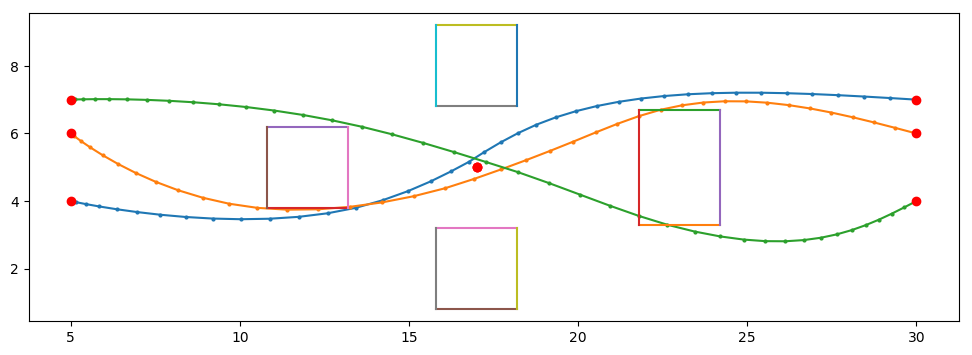

In [15]:
using PyPlot
figure(figsize=(12,4))
for n in 1:N 
    plot( xopt[1,:,n][:], xopt[2,:,n][:],".-", markersize=4 )
end

for n in 1:N
    plot( xw[1,:,n], xw[2,:,n], "r.", markersize=12 )
end

for o in 1:ko
    # lower and upper lines
    plot(linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10),
        0.*linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10) .+ (xo[2,o] - bbo[2,o]))
    plot(linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10),
        0.*linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10) .+ (xo[2,o] + bbo[2,o]))

    # left and right lines
    plot(0.*linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10) .+ (xo[1,o] - bbo[1,o]),
        linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10))
    plot(0.*linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10) .+ (xo[1,o] + bbo[1,o]),
        linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10))
end
axis("equal");